In [1]:
!pip install -U scipy==1.2.0
!pip install -U tensorflow==1.15.0
!pip install -U keras==2.2.5

     |████████████████████████████████| 26.6MB 107kB/s 
ERROR: umap-learn 0.4.3 has requirement scipy>=1.3.1, but you'll have scipy 1.2.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 412.3MB 36kB/s 
     |████████████████████████████████| 512kB 37.4MB/s 
     |████████████████████████████████| 3.8MB 3.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e54492f8f127b22b07a554eb745fc9bf8a96ce40f47bd2594d812cb4b9ea6572
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks/VPC/StyleTransfer
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/VPC/StyleTransfer
estilo.jpg		resultado_dot50_dot50.png  torrent.jpg
resultado_dot50_10.png	resultado.png
resultado_dot50_80.png	StyleTransfer.ipynb


(1, 512, 512, 3)
(1, 512, 512, 3)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D) 

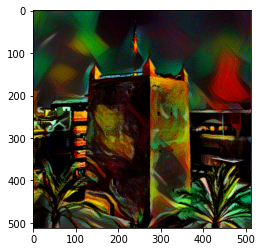

In [21]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

content_image = Image.open('torrent.jpg')
content_image = content_image.resize((512,512))

style_image = Image.open('estilo.jpg')
style_image = style_image.resize((512,512))

content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

print(content_array.shape)
print(style_array.shape)

a_mean = np.mean(content_array[:, :, :, 0])
b_mean = np.mean(content_array[:, :, :, 1])
c_mean = np.mean(content_array[:, :, :, 2])

content_array[:, :, :, 0] -= a_mean
content_array[:, :, :, 1] -= b_mean
content_array[:, :, :, 2] -= c_mean

style_array[:, :, :, 0] -= a_mean
style_array[:, :, :, 1] -= b_mean
style_array[:, :, :, 2] -= c_mean

height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
model.summary()

content_weight = 0.5
style_weight = 100.0
total_variation_weight = 1.0

layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

loss = backend.variable(0.)

def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

layer_features=layers['block2_conv2']
print(layer_features.shape)
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

cv2.imwrite('resultado.png', x)
imgplot = plt.imshow(load_img('resultado.png'))
plt.show()